In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Projeto - Métodos Regressivos e Séries Temporais

A idéia deste notebook é servir como exploração para a competição https://www.kaggle.com/competitions/store-sales-time-series-forecasting/. A competição completa é complexa demais para ser desenvolvida em classe (a idéia deste projeto é ocupar um sábado do Part Time, ao final da semana de métodos regressivos) - mas é possível simplificar o objetivo da competição trabalhando sobre um sub-conjunto de dados.

A competição é sobre previsão de demanda em lojas - o objetivo é prever a demanda de diversas categorias de produto ao longo de diversas lojas. 

In [3]:
tb_sales = pd.read_csv("data/train.csv")
tb_sales["date"] = pd.to_datetime(tb_sales["date"])


In [4]:
tb_sales.groupby("family")["sales"].sum().sort_values(ascending=False).head()


family
GROCERY I    3.434627e+08
BEVERAGES    2.169545e+08
PRODUCE      1.227047e+08
CLEANING     9.752129e+07
DAIRY        6.448771e+07
Name: sales, dtype: float64

In [5]:
tb_transactions = pd.read_csv("data/transactions.csv")
tb_transactions["date"] = pd.to_datetime(tb_transactions["date"])


In [6]:
tb_sales_trans = tb_sales.merge(tb_transactions, on=["store_nbr", "date"])
tb_sales_trans["sales_per_trans"] = (
    tb_sales_trans["sales"] / tb_sales_trans["transactions"]
)


In [7]:
tb_sales_trans.groupby(["family", "store_nbr"])["sales"].sum().sort_values(
    ascending=False
).head(10)


family     store_nbr
GROCERY I  44           1.635794e+07
           45           1.631580e+07
           47           1.548512e+07
           46           1.431522e+07
BEVERAGES  44           1.338753e+07
GROCERY I  3            1.293655e+07
           48           1.280260e+07
BEVERAGES  45           1.133832e+07
           3            1.131410e+07
GROCERY I  49           1.106557e+07
Name: sales, dtype: float64

<AxesSubplot:xlabel='date', ylabel='transactions'>

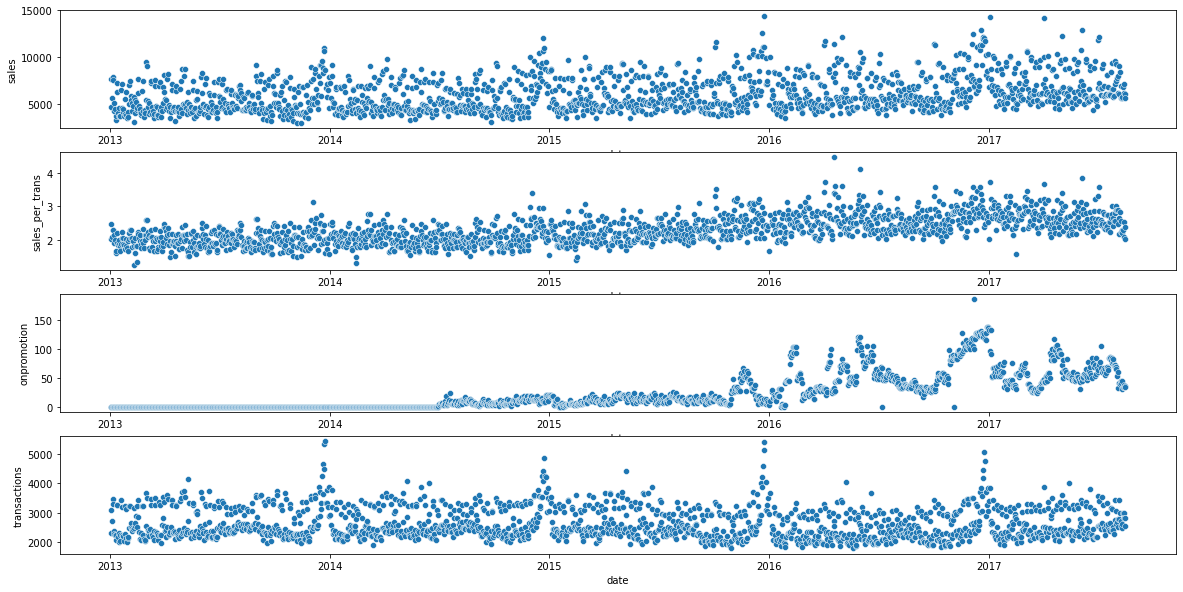

In [8]:
CAT = "GROCERY I"
STORE = 50
tb_cat = tb_sales_trans[tb_sales_trans["family"] == CAT].copy()
tb_cat_store = tb_cat[(tb_cat["store_nbr"] == STORE)].copy()
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
sns.scatterplot(data=tb_cat_store, x="date", y="sales", ax=ax[0])
sns.scatterplot(data=tb_cat_store, x="date", y="sales_per_trans", ax=ax[1])
sns.scatterplot(data=tb_cat_store, x="date", y="onpromotion", ax=ax[2])
sns.scatterplot(data=tb_cat_store, x="date", y="transactions", ax=ax[3])


<AxesSubplot:xlabel='date', ylabel='transactions'>

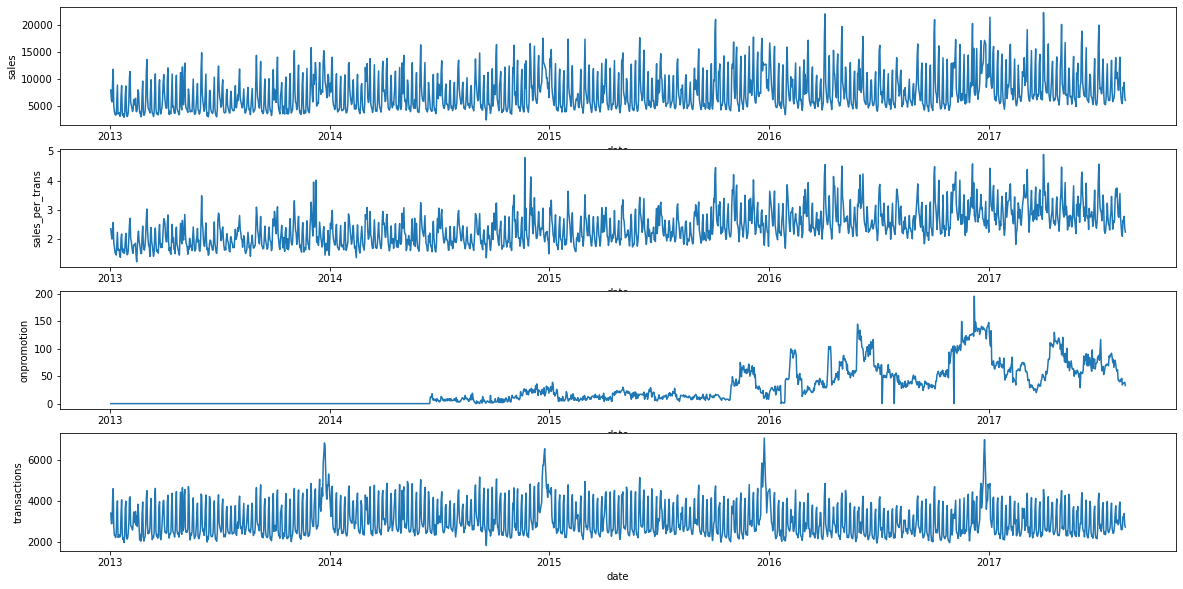

In [9]:
CAT = "GROCERY I"
STORE = 48
tb_cat = tb_sales_trans[tb_sales_trans["family"] == CAT].copy()
tb_cat_store = tb_cat[(tb_cat["store_nbr"] == STORE)].copy()
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
sns.lineplot(data=tb_cat_store, x="date", y="sales", ax=ax[0])
sns.lineplot(data=tb_cat_store, x="date", y="sales_per_trans", ax=ax[1])
sns.lineplot(data=tb_cat_store, x="date", y="onpromotion", ax=ax[2])
sns.lineplot(data=tb_cat_store, x="date", y="transactions", ax=ax[3])


<AxesSubplot:xlabel='date', ylabel='transactions'>

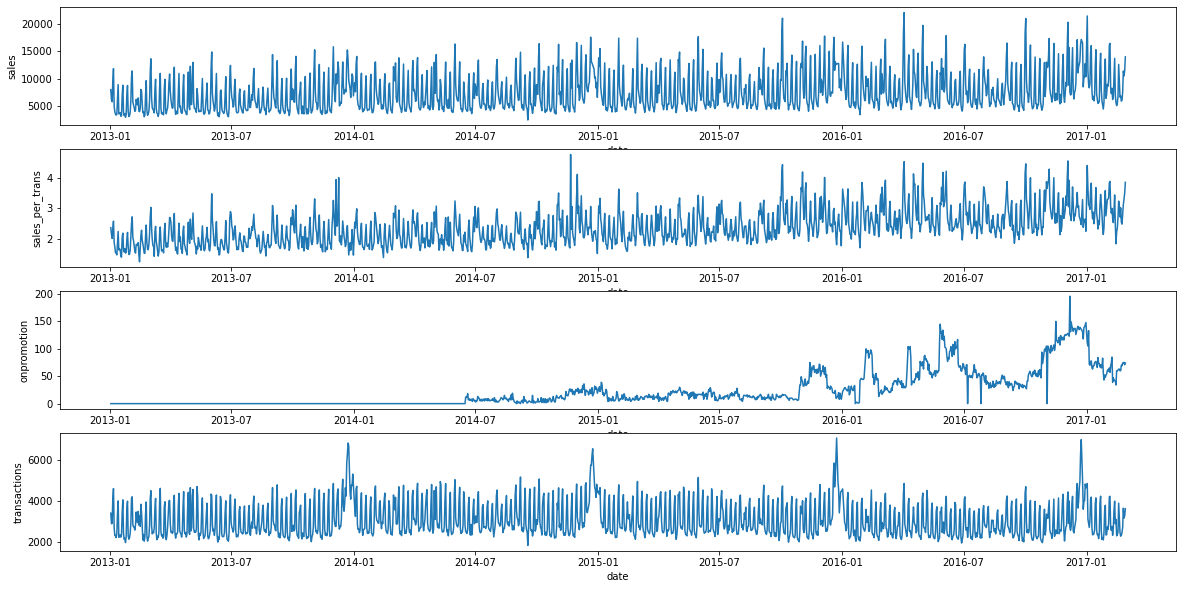

In [10]:
CAT = "GROCERY I"
STORE = 48
test_end_date = "2017-03-01"
tb_cat = tb_sales_trans[tb_sales_trans["family"] == CAT].copy()
tb_cat_store = tb_cat[(tb_cat["store_nbr"] == STORE)].copy()
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
sns.lineplot(
    data=tb_cat_store[tb_cat_store["date"] < test_end_date],
    x="date",
    y="sales",
    ax=ax[0],
)
sns.lineplot(
    data=tb_cat_store[tb_cat_store["date"] < test_end_date],
    x="date",
    y="sales_per_trans",
    ax=ax[1],
)
sns.lineplot(
    data=tb_cat_store[tb_cat_store["date"] < test_end_date],
    x="date",
    y="onpromotion",
    ax=ax[2],
)
sns.lineplot(
    data=tb_cat_store[tb_cat_store["date"] < test_end_date],
    x="date",
    y="transactions",
    ax=ax[3],
)


# Criando sub-conjunto de dados

Vamos quebrar a competição em duas: um grupo pode prever o **# de transações** enquanto o outro poderá prever o **# de itens vendidos por transação**. Ao invés de trabalhar com todas as categorias e lojas, vamos trabalhar apenas com a categoria `GROCERY I` nas lojas `48` e `50` - essas combinações apresentam séries bem regulares como visto acima.

In [11]:
project1_vars = ["date", "store_nbr", "onpromotion", "sales_per_trans"]
project2_vars = ["date", "store_nbr", "onpromotion_store", "transactions"]
mask_stores = tb_sales_trans["store_nbr"].isin([48, 50])
mask_date = tb_sales_trans["date"] < test_end_date
mask_category = tb_sales_trans["family"] == "GROCERY I"


In [12]:
tb_sales_project = (
    tb_sales_trans.loc[mask_stores & mask_date & mask_category, project1_vars]
    .copy()
    .reset_index()
)


In [13]:
tb_trans_project = (
    tb_sales_trans[mask_stores & mask_date]
    .groupby(["date", "store_nbr"])
    .agg(
        onpromotion_store=pd.NamedAgg("onpromotion", "sum"),
        transactions=pd.NamedAgg("transactions", "max"),
    )
    .reset_index()
)


In [14]:
train_end_date = "2016-12-01"


In [15]:
tb_sales_project = tb_sales_project.sort_values(["store_nbr", "date"]).drop(
    "index", axis=1
)
tb_sales_project["id"] = range(tb_sales_project.shape[0])
tb_sales_project = tb_sales_project[["id"] + project1_vars]
tb_sales_project_train = tb_sales_project[
    tb_sales_project["date"] < train_end_date
].copy()
tb_sales_project_test = tb_sales_project[
    tb_sales_project["date"] >= train_end_date
].copy()
tb_sales_project_test_sample = tb_sales_project_test.copy()
tb_sales_project_test_sample["transactions"] = 1
tb_sales_project_test_user = tb_sales_project_test.drop("sales_per_trans", axis=1)
tb_sales_project_train.to_csv("data project_1/train.csv", index=False)
tb_sales_project_test_user.to_csv("data project_1/test.csv", index=False)
tb_sales_project_test[["id", "sales_per_trans"]].rename(
    {"id": "Id", "sales_per_trans": "Expected"}, axis=1
).to_csv("data project_1/solution_kaggle.csv", index=False)
tb_sales_project_test_sample[["id", "sales_per_trans"]].rename(
    {"id": "Id", "sales_per_trans": "Predicted"}, axis=1
).to_csv("data project_1/sample_submission.csv", index=False)


In [16]:
tb_sales_project_test_sample


,id,date,store_nbr,onpromotion,sales_per_trans,transactions
2842,1421,2016-12-01,48,125,3.415447,1
2844,1422,2016-12-02,48,125,3.107233,1
2846,1423,2016-12-03,48,127,3.953392,1
2848,1424,2016-12-04,48,128,4.576011,1
2850,1425,2016-12-05,48,126,3.059413,1
...,...,...,...,...,...,...
3009,3013,2017-02-24,50,69,2.746144,1
3011,3014,2017-02-25,50,72,2.730567,1
3013,3015,2017-02-26,50,64,2.308953,1
3015,3016,2017-02-27,50,69,2.785742,1


In [17]:
tb_trans_project = tb_trans_project.sort_values(["store_nbr", "date"])
tb_trans_project["id"] = range(tb_trans_project.shape[0])
tb_trans_project = tb_trans_project[["id"] + project2_vars]
tb_trans_project_train = tb_trans_project[
    tb_trans_project["date"] < train_end_date
].copy()
tb_trans_project_test = tb_trans_project[
    tb_trans_project["date"] >= train_end_date
].copy()
tb_trans_project_test_sample = tb_trans_project_test.copy()
tb_trans_project_test_sample["sales_per_trans"] = 1
tb_trans_project_test_user = tb_trans_project_test.drop("transactions", axis=1)
tb_trans_project_train.to_csv("data project_2/train.csv", index=False)
tb_trans_project_test_user.to_csv("data project_2/test.csv", index=False)
tb_trans_project_test[["id", "transactions"]].rename(
    {"id": "Id", "transactions": "Expected"}, axis=1
).to_csv("data project_2/solution_kaggle.csv", index=False)
tb_trans_project_test_sample[["id", "transactions"]].rename(
    {"id": "Id", "transactions": "Predicted"}, axis=1
).to_csv("data project_2/sample_submission.csv", index=False)


In [18]:
tb_trans_project_train

,id,date,store_nbr,onpromotion_store,transactions
0,0,2013-01-02,48,0,3397
2,1,2013-01-03,48,0,2887
4,2,2013-01-04,48,0,2900
6,3,2013-01-05,48,0,4084
8,4,2013-01-06,48,0,4591
...,...,...,...,...,...
2833,2925,2016-11-26,50,290,3471
2835,2926,2016-11-27,50,294,3298
2837,2927,2016-11-28,50,289,2355
2839,2928,2016-11-29,50,253,2010


<AxesSubplot:xlabel='date', ylabel='transactions'>

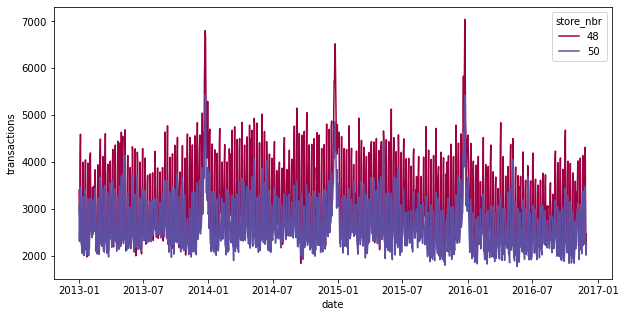

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=tb_trans_project_train,
    x="date",
    y="transactions",
    hue="store_nbr",
    palette="Spectral",
)


<AxesSubplot:xlabel='date', ylabel='sales_per_trans'>

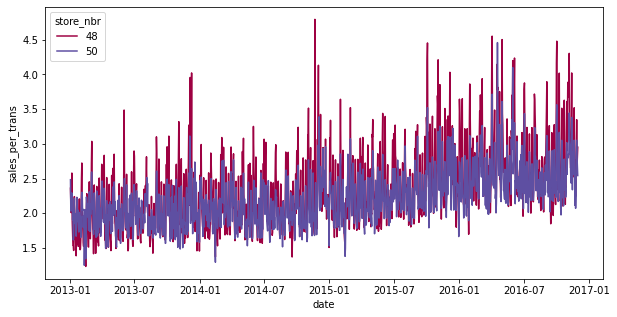

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=tb_sales_project_train,
    x="date",
    y="sales_per_trans",
    hue="store_nbr",
    palette="Spectral",
)

## Dados Auxiliares

In [273]:
tb_stores = pd.read_csv("data/stores.csv")
tb_oil = pd.read_csv("data/oil.csv", parse_dates=["date"])
tb_holiday = pd.read_csv("data/holidays_events.csv")


In [274]:
tb_stores.to_csv("data project_1/stores.csv", index=False)
tb_oil[tb_oil["date"] < train_end_date].to_csv("data project_1/oil.csv", index=False)
tb_holiday.to_csv("data project_1/holidays_events.csv", index=False)


In [275]:
tb_stores.to_csv("data project_2/stores.csv", index=False)
tb_oil[tb_oil["date"] < train_end_date].to_csv("data project_2/oil.csv", index=False)
tb_holiday.to_csv("data project_2/holidays_events.csv", index=False)


In [276]:
tb_oil.head()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

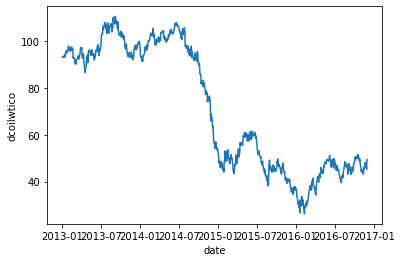

In [277]:
sns.lineplot(data=tb_oil[tb_oil["date"] < train_end_date], x="date", y="dcoilwtico")


In [278]:
tb_holiday[tb_holiday["locale"] == "National"]


,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [279]:
tb_holiday["locale"].unique()


array(['Local', 'Regional', 'National'], dtype=object)

In [280]:
mask_feriados_quito = (tb_holiday["locale"] == "National") | (
    (tb_holiday["locale"] == "Local") & (tb_holiday["locale_name"] == "Quito")
)
tb_holiday_48 = tb_holiday.loc[mask_feriados_quito, ["date", "type", "description", "transferred"]]
tb_holiday_48['store_nbr'] = '48'
mask_feriados_quito = (tb_holiday["locale"] == "National") | (
    (tb_holiday["locale"] == "Local") & (tb_holiday["locale_name"] == "Ambato")
)
tb_holiday_50 = tb_holiday.loc[mask_feriados_quito, ["date", "type", "description", "transferred"]]
tb_holiday_50['store_nbr'] = '50'
tb_final_holi = pd.concat([tb_holiday_48, tb_holiday_50], axis = 0)

In [281]:
mask_dia_regular = df['type_y'].isna()
mask_fer_trans = df['transferred'] == True

df['cat_feriado'] = 'feriado_regular'
df.loc[mask_dia_regular, 'cat_feriado'] = 'dia_regular'
df.loc[mask_fer_trans, 'cat_feriado'] = 'feriado_transf'



NameError: name 'df' is not defined

In [ ]:

tb_trans_project

,id,date,store_nbr,onpromotion_store,transactions
0,0,2013-01-02,48,0,3397
2,1,2013-01-03,48,0,2887
4,2,2013-01-04,48,0,2900
6,3,2013-01-05,48,0,4084
8,4,2013-01-06,48,0,4591
...,...,...,...,...,...
3009,3013,2017-02-24,50,354,2399
3011,3014,2017-02-25,50,169,3036
3013,3015,2017-02-26,50,157,2379
3015,3016,2017-02-27,50,164,2539


In [ ]:
if []:
    print('oi')
else:
    print('ola')

ola


In [ ]:
import re
re.findall('Navidad', 'Primer Grito de Independencia')

[]

In [ ]:
import re
tb_final_holi['feliz_navidad'] = tb_final_holi['description'].map(lambda x: 1 if re.findall('Navidad', x) else 0)
tb_final_holi['navidad'] = np.where(tb_final_holi['description'] == 'Navidad', 1, 0)

In [ ]:
tb_final_holi

,date,type,description,transferred,store_nbr,feliz_navidad,navidad,periodo_natal
14,2012-08-10,Holiday,Primer Grito de Independencia,False,48,0,0,0.0
19,2012-10-09,Holiday,Independencia de Guayaquil,True,48,0,0,0.0
20,2012-10-12,Transfer,Traslado Independencia de Guayaquil,False,48,0,0,0.0
21,2012-11-02,Holiday,Dia de Difuntos,False,48,0,0,0.0
22,2012-11-03,Holiday,Independencia de Cuenca,False,48,0,0,0.0
...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,Navidad-3,False,50,1,0,1.0
346,2017-12-23,Additional,Navidad-2,False,50,1,0,1.0
347,2017-12-24,Additional,Navidad-1,False,50,1,0,NaN
348,2017-12-25,Holiday,Navidad,False,50,1,1,NaN
